In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion #unites all arrays into one array
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


import re
import warnings
warnings.filterwarnings('ignore')

child = pd.read_csv("kiva_loans.csv")
# loan = pd.read_csv("loan_theme_ids.csv")
# regloan = pd.read_csv("loan_themes_by_region.csv")
# region = pd.read_csv("kiva_mpi_region_locations.csv")


In [10]:
child.disbursed_time = pd.to_datetime(child.disbursed_time)
child.posted_time = pd.to_datetime(child.posted_time)
child.funded_time = pd.to_datetime(child.funded_time)

child.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39,2013-12-17 08:00:00,2014-01-02 10:06:32,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08,2013-12-17 08:00:00,2014-01-02 09:17:23,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07,2013-12-17 08:00:00,2014-01-01 16:01:36,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11,2013-12-24 08:00:00,2014-01-01 13:00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19,2013-12-17 08:00:00,2014-01-01 19:18:51,14.0,16,NaN,female,monthly,2014-01-01


# LOANS

In [11]:
"""Thanks to @SRK"""
loan_sec = child['sector'].value_counts()
trace = go.Bar(
    y=loan_sec.index[::-1],
    x=loan_sec.values[::-1],
    orientation = 'h',
    marker=dict(
        color=loan_sec.values[::-1],
        colorscale = 'Picnic',
        reversescale = True
              ),
            )

layout = dict(
    title='Distribution of loans by sector',
    xaxis=dict(
        title='Number of loans'),
            )

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Loans_by_sector')
print("It would be interesting to dig deeper and see what Personal Use refers to")

It would be interesting to dig deeper and see what Personal Use refers to


In [12]:
loan_activity = child['activity'].value_counts().head(40)
trace = go.Bar(
    x=loan_activity.index[::-1],
    y=loan_activity.values[::-1],
    orientation = 'v',
    marker=dict(
        color=loan_activity.values[::-1],
        colorscale = 'Picnic',
        reversescale = True
              ),
            )

layout = dict(
    title='Distribution of loans by activity (top 40)',
    yaxis=dict(
        title='Number of loans'),
    xaxis=dict(tickfont=dict(size=8))
            )

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Loans_by_activity')

# Education Loans 
* for our Children, Sons, and Daughters

In [13]:
edu_all = child[child['sector']=='Education']

c_child = edu_all['use'].apply(lambda x: len(re.findall(r"(child)", str(x)))) 
c_son = edu_all['use'].apply(lambda x: len(re.findall(r"([\s.,:;]son[\s.,:;s])|([\s.,:;]son\s*[.'’]+)", str(x)))) 
c_daughter = edu_all['use'].apply(lambda x: len(re.findall(r"([\s.,:;]daughter[\s.,:;s])|([\s.,:;]daughter\s*[.'’]+)", str(x))))

c_child = c_child[c_child.values>0].index
c_son = c_son[c_son.values>0].index
c_daughter = c_daughter[c_daughter.values>0].index

#unite indices of all loans with son, daughter, or child in their description
children = c_child.union(c_son)
children = children.union(c_daughter)

edu_child = child.iloc[children,:]

In [14]:
#merge expected years of schooling into dataset

schooling = pd.read_csv("schooling.csv")
schooling = schooling.rename(index=str, columns={"Human Development Index (HDI) ": "HDI", \
                                     "Gross national income (GNI) per capita":"GNI", \
                                     "Country": "country", \
                                     "GNI per capita rank minus HDI rank": "GNI_rank"})

edu_country = edu_child.groupby('country')['loan_amount'].sum()
edu_country = pd.DataFrame(edu_country).reset_index()

edu_country = edu_country.merge(schooling, on='country', how='left')

In [15]:
edu_country.dropna(inplace=True)
edu_country = edu_country[edu_country.loan_amount < 30000]

data = [go.Scatter(
    y = edu_country['Mean years of schooling'],
    x = edu_country['loan_amount'],
    mode='markers+text',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size= (7 * (edu_country.HDI))**2,
        color=edu_country['Mean years of schooling'],
        colorscale='Portland',
        reversescale=True,
        showscale=True)
    ,text=edu_country['country']
    ,textposition=["top center"]
)]
layout = go.Layout(
    autosize=True,
    title='Years of Schooling vs. Sum of Education Loans for Children (under 30000 USD)',
    hovermode='closest',
    xaxis= dict(title='Sum of Loans', ticklen= 5, showgrid=True, zeroline=False, showline=False),
    yaxis=dict(title='Mean Years of Schooling', showgrid=True, zeroline=False, ticklen=5, gridwidth=2)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter_schooling_loans')

There appears to be a small correlation (quite intuitive I would say):
* The fewer years of schooling per country, the more loans requested for children's education.
* The smaller the Human Development Index (diameter of bubbles), the more loans requested for children's education

**Education loans (children and non-related children)**

In [16]:
edu_for_everyone = child[child['sector']=='Education']['country'].value_counts()
edu_for_everyone = pd.DataFrame(edu_for_everyone).reset_index()
edu_for_everyone.columns = ['country', 'num_all_loans']

edu_for_children = edu_child['country'].value_counts()
edu_for_children = pd.DataFrame(edu_for_children).reset_index()
edu_for_children.columns = ['country', 'num_child_loans']

edu = edu_for_children.merge(edu_for_everyone, on='country', how='right')
edu.fillna(0, inplace=True)
edu['percent'] = edu['num_child_loans']/edu['num_all_loans']
edu['other_loans'] = edu['num_all_loans']-edu['num_child_loans']

In [17]:
edu = edu.sort_values(by='num_child_loans', ascending=False)

In [18]:
edu = edu[:15]
trace1 = go.Bar(
    x=edu['country'],
    y=edu['num_child_loans'],
    name='Child education_loans'
)
trace2 = go.Bar(
    x=edu['country'],
    y=edu['other_loans'],
    name='Non-child education_loans'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title="Education loans for child and non-child related reasons",
    yaxis=dict(title="Number of loans")
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

Lebanon, Vietnam, and Nigeria appear to need more loans for their childrens' education. This might be because of several reasons:
* Many loans for children are asked for primary education. Perhaps primary education in these countries is expensive
* Perhaps familes in these countries have more children, which would make it harder to pay for their education
* Maybe they realized that they are more likely to get a loan for children as opposed to adults
* Or maybe it's based on non-education related reasons

# Nigeria Education Loans 
* Let's take a deeper look at Nigeria who has the 2nd highest percentage of loans for children

In [19]:
nigeria = edu_child.copy()
nigeria = nigeria[nigeria.country=='Nigeria']
print(nigeria.activity.value_counts())

Primary/secondary school costs    936
Higher education costs              1
Name: activity, dtype: int64


In [20]:
print('All education loans for children are managed through 1 field partner with ID 288: "Babban Gona Farmers Organization"')
print(nigeria.partner_id.value_counts())

All education loans for children are managed through 1 field partner with ID 288: "Babban Gona Farmers Organization"
288.0    937
Name: partner_id, dtype: int64


In [21]:
print("The borrowers are overwhelmingly men")
print(nigeria.borrower_genders.value_counts())

The borrowers are overwhelmingly men
male      849
female     88
Name: borrower_genders, dtype: int64


Why are they borrowing money for their childrens' education?

In [22]:
for x in nigeria.use.head(10):
    print (x)

to meet urgent expenses such as child school fees, food and farm loan repayment, thereby eliminating the pressure to sell corn at low prices and increasing income by up to 37%
To meet urgent expenses and pay for child school fees, food and farm loan repayment, thereby eliminating the pressure to sell corn at low prices, and thus increasing income by up to 37%
To access a loan to meet urgent expenses, including child school fees, food and farm loan repayments, thereby eliminating the pressure to sell corn at low prices, and thus increasing income by up to 37%
To access a loan to meet urgent expenses such as child school fees, food and farm loan repayment, thereby eliminating the pressure to sell corn at low prices, and thus increasing income by up to 37%
To pay for child's school fees and uniforms; eliminating pressure to sell corn for low prices at harvest.
To pay for child school fees and uniforms, eliminating pressure to sell corn for low prices at harvest.
To pay for her children's 

* It turns out that many of Nigerian education loans are highly related to agricultural reasons as well

**Timescale of Loans (Nigeria)**

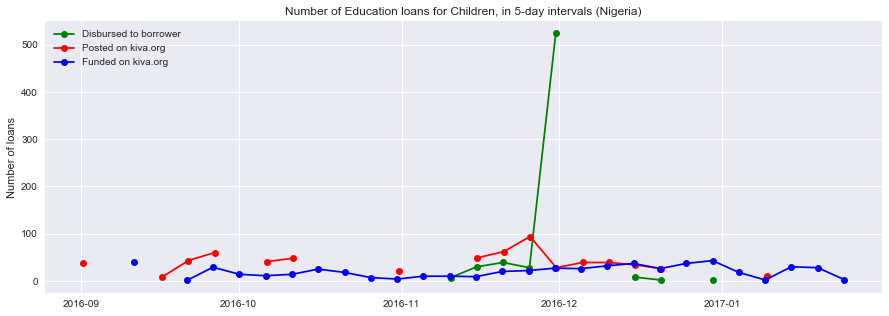

In [23]:
nigeria = edu_child.copy()
nigeria = nigeria[nigeria.country=='Nigeria']
nigeria['num']= 1 #add 1 to each row so we can count number of loans 

disbursed = nigeria.set_index(nigeria['disbursed_time'])
disbursed = disbursed.loc['2016-09':'2017-02'].resample('5D').sum()

posted = nigeria.set_index(nigeria['posted_time'])
posted = posted.loc['2016-09':'2017-02'].resample('5D').sum()

funded = nigeria.set_index(nigeria['funded_time'])
funded = funded.loc['2016-09':'2017-02'].resample('5D').sum()

plt.figure(figsize=(15,5))
plt.plot(disbursed['num'], color='green', label='Disbursed to borrower', marker='o')
plt.plot(posted['num'], color='red', label='Posted on kiva.org', marker='o')
plt.plot(funded['num'], color='blue', label='Funded on kiva.org', marker='o')
plt.legend(loc='upper left')
plt.title("Number of Education loans for Children, in 5-day intervals (Nigeria)")
plt.ylabel("Number of loans")
plt.show()

Apparently, all 2016 education loans for children were disbursed to borrowers in December, despite not being fully funded yet

# Gender Analysis of Education Loans

In [24]:
ed = child[child['sector']=='Education']
son = ed['use'].apply(lambda x: len(re.findall(r"([\s.,:;]son[\s.,:;s])|([\s.,:;]son\s*[.'’]+)", str(x)))) 
daughter = ed['use'].apply(lambda x: len(re.findall(r"([\s.,:;]daughter[\s.,:;s])|([\s.,:;]daughter\s*[.'’]+)", str(x))))

son = son[son.values>0]
daughter = daughter[daughter.values>0]

ed_son = child.iloc[son.index,:]
ed_daughter = child.iloc[daughter.index,:]

In [25]:
girl = round(ed_daughter.loan_amount.mean(),2)
boy = round(ed_son.loan_amount.mean(),2)

labels = ['Daughters','Sons']
values = [girl,boy]
colors = ['#38e1a3', '#ffeb38']

trace = go.Pie(labels=labels, values=values,
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=1)))
layout = go.Layout(
        title="Average Education Loans (USD) for Sons and Daughters")

fig = go.Figure(data=[trace], layout=layout)

py.iplot(fig, filename='basic_pie_chart')

Hmmmmm... Parents are asking an average of $63 more for sons than for daughters. It would probably be appropriate to give more money to girls, given that they face more challenges than boys, especially when trying to complete their education.
Some of the Challenges girls face in many countries are:
* missing school because they are asked to help with errands around the house
* missing school because they don't have feminine hygiene products
* having little time to complete their homework because they are asked to watch over siblings

# Gender Analysis of Education Loans, by Country

In [26]:
edu_all = child[child['sector']=='Education']

c_son = edu_all['use'].apply(lambda x: len(re.findall(r"([\s.,:;]son[\s.,:;s])|([\s.,:;]son\s*[.'’]+)", str(x)))) 
c_daughter = edu_all['use'].apply(lambda x: len(re.findall(r"([\s.,:;]daughter[\s.,:;s])|([\s.,:;]daughter\s*[.'’]+)", str(x))))

c_son = c_son[c_son.values>0].index
c_daughter = c_daughter[c_daughter.values>0].index

#unite indices of all loans with son, daughter, or child in their description
son_dautr = c_daughter.union(c_son)

#slice original dataset to extract only son_daughter rows
edu_son_dautr = child.iloc[son_dautr,:]


dollars = edu_son_dautr.groupby('country')['loan_amount'].sum()
all_children = pd.DataFrame(dollars).reset_index()

In [27]:
data = [ dict(
        type = 'choropleth',
        locations = all_children['country'],
        locationmode = 'country names',
        z = all_children['loan_amount'],
        text = all_children['country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.20,"rgb(40, 60, 190)"],[0.40,"rgb(70, 100, 245)"],\
            [0.55,"rgb(90, 120, 245)"],[0.75,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(280,10,30)',  # color of country borders
                width = 0.5                # width of country borders
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Loans (USD)'),
      ) ]

layout = dict(
    title = 'Total Education Loans for sons and daughters, by Country',
    geo = dict(
        showframe = True,                 # frame of full map
        showcoastlines = True,            # coastline of full map
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='education-loans-for-children-world-map')
print("Southern hemisphere is predominantely the main recipient of education loans")

Southern hemisphere is predominantely the main recipient of education loans


# Gender Analysis of All Loans

In [28]:
b = child['use'].apply(lambda x: len(re.findall(r"([\s.,:;]son[\s.,:;s])|([\s.,:;]son\s*[.'’]+)", str(x)))) 
g = child['use'].apply(lambda x: len(re.findall(r"([\s.,:;]daughter[\s.,:;s])|([\s.,:;]daughter\s*[.'’]+)", str(x)))) 

b = b[b.values>0]
g = g[g.values>0]

b = child.iloc[b.index,:]
g = child.iloc[g.index,:]

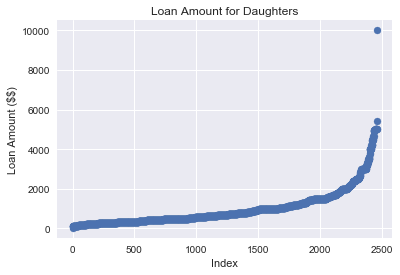

In [29]:
plt.scatter(x=range(g.shape[0]), y=np.sort(g.loan_amount.values))
plt.title('Loan Amount for Daughters')
plt.xlabel('Index')
plt.ylabel('Loan Amount (\$$)')
plt.show()

let's Truncate to eliminate outliers and display historgram for sons and daughters

In [30]:
# For Girls

# ulimit (4925.0) is the value below which 99% of observations in this group of loan observations fall
# i.e. 99% of observations in this group of loans fall under $4925.0
ulimit = np.percentile(g.loan_amount.values, 99) 
llimit = np.percentile(g.loan_amount.values, 1) # 1% of observations in this group fall below llimit ($125.0)

g['loan_trunc'] = g['loan_amount'].copy()
g['loan_trunc'].loc[g['loan_amount']>ulimit] = ulimit # if loan > $4925, assign 4925 to loan_amount 
g['loan_trunc'].loc[g['loan_amount']<llimit] = llimit # if loan < $125, assign 125 to loan_amount

# For Boys
ulimit = np.percentile(b.loan_amount.values, 99) 
llimit = np.percentile(b.loan_amount.values, 1) # 1% of observations in this group fall below llimit ($125.0)

b['loan_trunc'] = b['loan_amount'].copy()
b['loan_trunc'].loc[b['loan_amount']>ulimit] = ulimit
b['loan_trunc'].loc[b['loan_amount']<llimit] = llimit

**CDF**
* The cumulative distribution function tells us the probability that an observation drawn from a distribution would fall below a certian value

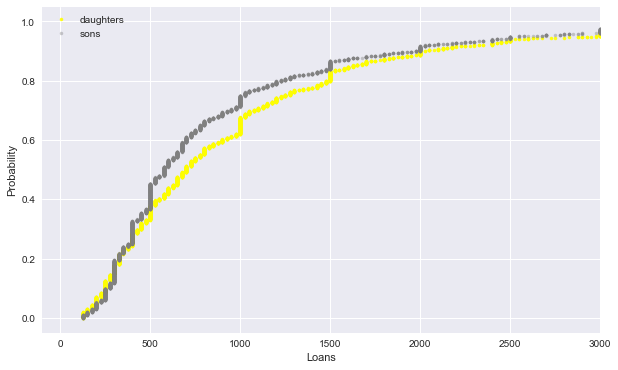

In [31]:
"""Compute ECDF for a one-dimensional array of measurements."""
def ecdf(data, datab):
    
    # Number of data points: n
    n = len(data)
    nb= len(datab)

    # x-data for the ECDF: x
    x = np.sort(data)
    xb= np.sort(datab)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    yb= np.arange(1, nb+1) / nb

    return x, y, xb, yb

"""Plot the ECDF"""
x, y, xb, yb = ecdf(g.loan_trunc.values, b.loan_trunc.values)

plt.figure(figsize=(10,6))
plt.plot(x,y, linestyle='none', marker='.', color='yellow', alpha=0.9)
plt.plot(xb,yb, linestyle='none', marker='.', color='gray', alpha=0.4)

plt.xlabel("Loans")
plt.ylabel("Probability")
plt.legend(('daughters','sons'))
plt.xlim((-100,3000))
plt.show()

* Between the 35th and 80th percentile, the loans for girls are of a higher value than for boys. (a reminder that our data are truncated.)
* if we look at the 60th percentile we see that there is a 60% probability that a random loan from girls would fall under \$900. For boys: \$600

**Number of Loans by Sector**

In [32]:
boys = b.sector.value_counts()
girls = g.sector.value_counts()

trace1 = go.Bar(
    x=girls.index,
    y=girls.values,
    name='Loans for daughters'
)
trace2 = go.Bar(
    x=boys.index,
    y=boys.values,
    name='Loans for sons'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    title="Loans by sector (son or daughter)",
    yaxis=dict(title="Number of loans")
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar2')

Overall, more loans are asked for sons than for daughters. This could be due to families having more sons or investing more in boys, or a few other reasons. Interesting how only in the Housing sector more loans are asked for daughters than sons.

**Sum of Loans by Sector and Gender**

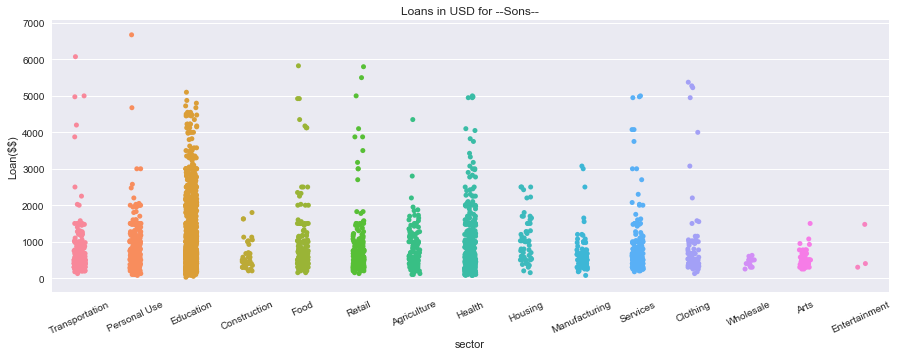

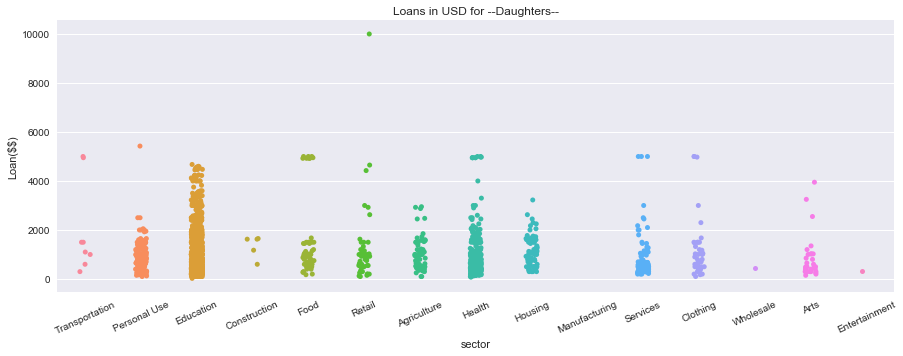

In [33]:
plt.figure(figsize=[15,5])
sns.stripplot(x='sector', y='loan_amount', data=b, jitter=True)
plt.title('Loans in USD for --Sons--')
plt.xticks(rotation=25)
plt.ylabel('Loan(\$$)')
plt.show()

plt.figure(figsize=[15,5])
sns.stripplot(x='sector', y='loan_amount', data=g, jitter=True, order=b.sector.unique())
plt.title('Loans in USD for --Daughters--')
plt.xticks(rotation=25)
plt.ylabel('Loan(\$$)')
plt.show()

It is remarkable that almost no Transportation or Manufacturing loans are asked for daughters.

In [220]:
for x in g[g.sector=='Transportation']['use'].head(20):
    print (x)

to buy a motorcycle for her daughter to get work.
To purchase a motorbike for her daughters to take to their work, and materials for her business.  
to maintain his car, which is his work vehicle.  With this income he will support his daughters and improve their quality of life.  
to buy a taxi so that she can generate better income for her daughter, who needs her mother's attention
to buy a vehicle to work for a taxi service in order to earn better income for her daughter.
 my wife and two daughters in ways i cannot express for there future not mine
to purchase her daughter a motorcycle ride to work.
her repair her husband's auto-rickshaw to provide income for the family and save for her daughter's wedding.


By digging into transportation loans, we see that daughters -- as opposed to sons -- are not the main recipient of the loans.


# Funding of Loans

In [35]:
"""Combine loans for all sons and daughters"""
sons = child['use'].apply(lambda x: len(re.findall(r"([\s.,:;]son[\s.,:;s])|([\s.,:;]son\s*[.'’]+)", str(x)))) 
dtrs = child['use'].apply(lambda x: len(re.findall(r"([\s.,:;]daughter[\s.,:;s])|([\s.,:;]daughter\s*[.'’]+)", str(x)))) 

sons = sons[sons.values>0].index
dtrs= dtrs[dtrs.values>0].index

# unite indices of all loans with son and daughter in their description
son_dtrs = sons.union(dtrs)

#slice original dataset to extract only son_dtrs rows
df = child.iloc[son_dtrs,:]

In [36]:
df['left_to_fund'] = df.loan_amount - df.funded_amount
child['left_to_fund'] = child.loan_amount - child.funded_amount

dm = df.left_to_fund.mean()
cm = child.left_to_fund.mean()
data = [go.Bar(
            x=['Sons and Daughters', 'All Loans'],
            y=[dm,cm]
    )]

layout = dict(
    title='Average $ Missing for Unfunded Loans',
    yaxis=dict(
        title="(USD)"),
            )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar2')
print("On average, loans for sons and daughters are $39 short when not fully funded, compared to $59 for all loans")

On average, loans for sons and daughters are $39 short when not fully funded, compared to $59 for all loans


**Let's look at percentage of unfunded loans by country**

In [37]:
all_loans = child['country'].value_counts()
all_loans = pd.DataFrame(all_loans).reset_index()
all_loans.columns = ['country', 'num_all_loans']

not_funded = child[child.left_to_fund>0]['country'].value_counts()
not_funded = pd.DataFrame(not_funded).reset_index()
not_funded.columns = ['country', 'unfunded_loans']

percent = all_loans.merge(not_funded, on='country', how='left')
percent['prcnt_unfunded'] = percent.unfunded_loans / percent.num_all_loans
percent['prcnt_unfunded'] = percent['prcnt_unfunded'].apply(lambda x: 0.0 if pd.isnull(x) else x)
percent['prcnt_unfunded'] = round((percent['prcnt_unfunded']*100),2)

In [38]:
data = [ dict(
        type = 'choropleth',
        locations = percent['country'],
        locationmode = 'country names',
        z = percent['prcnt_unfunded'],
        text = percent.country,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.20,"rgb(40, 60, 190)"],[0.40,"rgb(70, 100, 245)"],\
            [0.55,"rgb(90, 120, 245)"],[0.75,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(280,10,30)',  # color of country borders
                width = 0.5                # width of country borders
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = '% of Loans not funded'),
      ) ]

layout = dict(
    title = 'Percentage of Loans Not fully funded',
    geo = dict(
        showframe = True,                 # frame of full map
        showcoastlines = True,            # coastline of full map
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='unfunded loans')
print("36% of loans in the United States end up not fully funded. Perhaps that is due to rarely using a field partner")

36% of loans in the United States end up not fully funded. Perhaps that is due to rarely using a field partner


**Unfunded Loans by Sector**

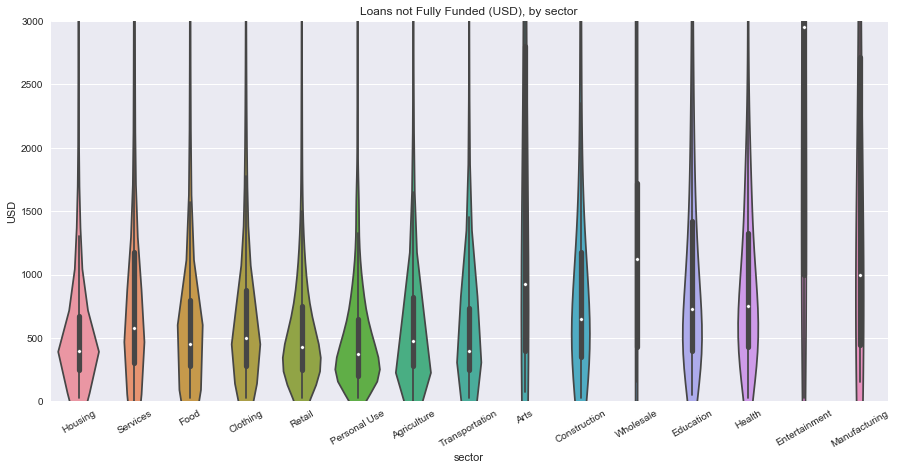

In [39]:
not_fully_funded = child[child.left_to_fund>0]
plt.figure(figsize=[15,7])
sns.violinplot(x='sector', y='left_to_fund', data=not_fully_funded)
plt.ylim((0,3000))
plt.ylabel("USD")
plt.title("Loans not Fully Funded (USD), by sector")
plt.xticks(rotation=30)
plt.show()

Although there are very few loans that don't get fully funded in the Arts, Wholesale, and Manufacturing, the median amount of money missing to fully fund their loans is approximately $1000: double the median amount in other sectors

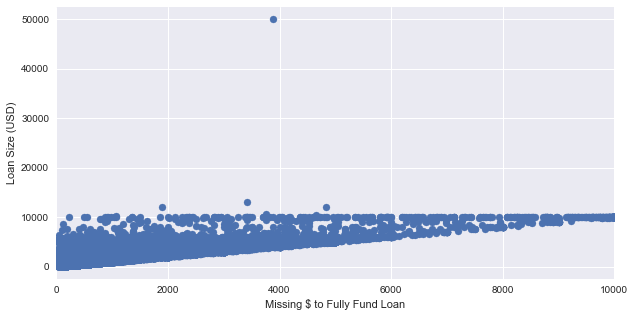

In [40]:
plt.figure(figsize=(10,5))
plt.scatter(not_fully_funded.left_to_fund, not_fully_funded.loan_amount)
plt.xlim((0,10000))
plt.xlabel("Missing $ to Fully Fund Loan")
plt.ylabel("Loan Size (USD)")
plt.show()

We see a slight correlation between size of loan and the amount of dollars that the loan fell short by

# Predicting Funding of Loans

Altough the complete funding of a loan depends on many factors and variables beyond this dataset, we shall try to use the basic information we have here to predict the likelyhood that a loan would be fully funded. 

Combine more categories from loans.csv in main loan dataframe

In [41]:
import os
os.getcwd()

'C:\\Users\\adam\\Desktop\\Python Course\\MS\\Child Development'

In [42]:
file = "C:\\Users\\adam\\Desktop\\Python Course\\MS\\Child Development\\loans.csv"
# file = "C:\\Users\\aschroeder\\Desktop\\Adam\\Anaconda\\Analyzing match data\\Child Development\\loans.csv"

In [43]:
big_data_loans = pd.read_csv(file, usecols=['loan_id','original_language','description',
                                            'description_translated','borrower_pictured'])
big_data_loans.rename(columns={'loan_id': 'id'}, inplace=True)
children = child.merge(big_data_loans, on='id', how='left')

In [79]:
funded = children.copy()

# drop rows where both description and translated are nulls
idx_desp_null = funded[(funded.description_translated.isnull()) & (funded.description.isnull())].index
funded.drop(idx_desp_null, inplace=True)

# for null translated rows, copy the english description from description column
funded[funded.description_translated.isnull()]
mask = funded.description_translated.isnull()
funded.loc[mask, 'description_translated'] = funded.description

# numerate borrower_pictured (none are false)
funded['num_borrower_pics'] = funded.borrower_pictured.map(lambda x: len(re.findall(r'true', x)))

# get dummies
funded = funded.join(funded.original_language.str.get_dummies(sep=', '))
funded = funded.join(funded.sector.str.get_dummies(sep=', '))
funded = funded.join(funded.repayment_interval.str.get_dummies(sep=', '))

# extract month and week that loan was posted to kiva
funded['posted_month'] = funded['posted_time'].apply(lambda x: x.month) 
funded['posted_week'] = funded['posted_time'].apply(lambda x: x.week) 

# add column to indicated if loan was fully funded 
funded['fully_funded'] = 0
funded['fully_funded'].loc[funded['left_to_fund']>0] = 1 # if loan not fully funded, insert 1

# drop unncessary columns
funded.drop(['borrower_pictured','description','original_language','date','tags','repayment_interval',\
             'country','lender_count','left_to_fund','left_to_fund','posted_time','disbursed_time',\
             'funded_time','region','partner_id','currency','country_code','sector','activity','funded_amount',\
             'id'], axis=1, inplace=True)

# drop NaNs
funded.dropna(subset=['borrower_genders','use'], inplace=True)

In [80]:
"""Categorize borrower_genders as only men, only female, or both genders present"""

#create list of strings in each row inside the borrower_genders column
funded.borrower_genders = funded.borrower_genders.map(lambda x: x.split(','))

# extract number of times females appear in each row as well as number of strings in each row
funded.borrower_genders = funded.borrower_genders.map(lambda x: [len(re.findall(r'(female)', str(x))), len(x)])

# x[0] is number of females; x[1] is length of list
# if number of female == len of list, then there are no men, only females in that row
# else, if number of female == 0 and len of list > 0, the there are only men
# else both genders are present
funded.borrower_genders = funded.borrower_genders.map(lambda x: 'female' if x[0]==x[1] 
                                                else ('male' if (x[0]==0) and (x[0]!=x[1]) else 'both'))


# get dummies
funded = funded.join(funded.borrower_genders.str.get_dummies(sep=', '))

# drop unncessary columns
funded.drop(['borrower_genders'], axis=1, inplace=True)

In [83]:
funded

,loan_amount,use,term_in_months,description_translated,num_borrower_pics,English,French,Portuguese,Russian,Spanish,...,bullet,irregular,monthly,weekly,posted_month,posted_week,fully_funded,both,female,male
0,300.0,"To buy seasonal, fresh fruits to sell.",12.0,Shabana is 32 years old and lives with her fiv...,1,1,0,0,0,0,...,0,1,0,0,1,1,0,0,1,0
1,575.0,to repair and maintain the auto rickshaw used ...,11.0,Rani is a 43-year-old lady who lives with her ...,2,1,0,0,0,0,...,0,1,0,0,1,1,0,0,1,0
2,150.0,To repair their old cycle-van and buy another ...,43.0,Praneswar is a rural housewife of 45 years. S...,1,1,0,0,0,0,...,1,0,0,0,1,1,0,0,1,0
3,200.0,to purchase an embroidery machine and a variet...,11.0,"Nasreen, age 40, is a mother of four children....",1,1,0,0,0,0,...,0,1,0,0,1,1,0,0,1,0
4,400.0,to purchase one buffalo.,14.0,Haneefan is a 38-year-old married woman who ha...,1,1,0,0,0,0,...,0,0,1,0,1,1,0,0,1,0
5,250.0,purchase leather for my business using ksh 20000.,4.0,I grew up in rural setting in Kakamega and in ...,1,1,0,0,0,0,...,0,1,0,0,1,1,0,0,1,0
6,200.0,To purchase a dairy cow and start a milk produ...,43.0,Kalpana is a 42-year-old woman from the villag...,1,1,0,0,0,0,...,1,0,0,0,1,1,0,0,1,0
7,400.0,to buy more hair and skin care products.,14.0,Khursheed is 51 years old married woman. She r...,1,1,0,0,0,0,...,0,0,1,0,1,1,0,0,1,0
8,475.0,"to purchase leather, plastic soles and heels i...",14.0,Mugdlain is a 48 year-old married woman who ma...,1,1,0,0,0,0,...,0,0,1,0,1,1,0,0,1,0
9,625.0,"to buy a stall, gram flour, ketchup, and coal ...",11.0,Naseem is a 57 year old married woman living i...,1,1,0,0,0,0,...,0,1,0,0,1,1,0,0,1,0


**Check for high correlations**

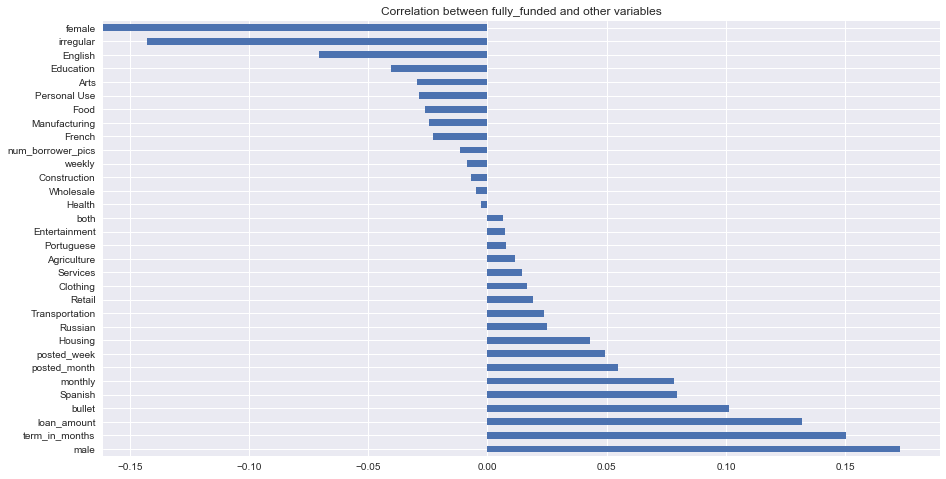

In [117]:
child_correlation = funded.corr()
plt.figure(figsize=(15,8))
(child_correlation
     .fully_funded
     .drop(['fully_funded']) # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())
plt.title("Correlation between fully_funded and other variables")
plt.show()

Correlations between funding of loan and other variables doesn't seem to be worringly high

**A function to combine the two text columns in the dataset, on which we will counvectorize later**

In [141]:
def combine_text_columns(data_frame): #drop numeric columns and labels
    """ converts all text in each row of data_frame to single vector because there are multiple columns of text.
    If it were one column of text it would be ok because it would automatically be considered a single vector. In 
    other words, this creates a single list of string per row because CountVectorizer in the pipeline 
    expects each row to just be a single string"""
    
    # Replace nans with blanks
    data_frame.fillna("", inplace=True)
    
    # Join all text items in a row that have a space in between
    return data_frame.apply(lambda x: " ".join(x), axis=1) #combine all blank slots inbetween text slots

# combine_text_columns(funded[['description_translated','use']])

# Predicting Funding of Loans

In [199]:
sample = funded[500000:600000]
x = sample.drop('fully_funded', axis=1)
y = sample['fully_funded']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13)

In [217]:
print('Percentage of loans that were fully funded: ',
      (sample.fully_funded.value_counts()[0]/sample.fully_funded.shape[0]),'%')

Percentage of loans that were fully funded:  0.94979 %


In [201]:
""" FunctionTransformer turns a function into an object that Pipeline can work with"""

numeric_columns = list(sample.drop(['use','description_translated','fully_funded'], axis=1).columns)

get_numeric_data = FunctionTransformer(lambda x: x[numeric_columns], validate=False)
get_text_data = FunctionTransformer(lambda x: combine_text_columns(x[['description_translated','use']]), validate=False)
                                                                                #validate=false means sklearn does not 
                                                                                #need to check for Nan or dtypes. 
                                                                                #I did that on my own.

print(get_text_data.fit_transform(X_train).shape)
print(get_numeric_data.fit_transform(X_train).shape)

(80000,)
(80000, 32)


In [203]:
pl = Pipeline([
        ('union', FeatureUnion(                      #unites both text and numeric arrays into one array
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data)
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data), #creates a single list of string per row
                    ('vectorizer', TfidfVectorizer(
                                                    stop_words='english',
                                                    strip_accents='unicode',
                                                    token_pattern=r'\w{2,}',
                                                    analyzer='word',,
                                                    min_df=5))
                ]))
             ]
        )), #(right here is where I would put interaction terms preprocessing such as PolynomialFeatures)
            #(right here is where I would put a scaler if I needed one)
        ('clf', LogisticRegression()) #compares each label column separately to the features 
    ])

In [204]:
import time

In [215]:
start_time=time.time()
param_grid = {'union__text_features__vectorizer__max_features': [25000,20000],
              'clf__C': [1],
              'union__text_features__vectorizer__ngram_range':[(1,1),(1,2)]
             } 
grid = GridSearchCV(pl, param_grid, cv=3, scoring='accuracy')

grid3 = grid.fit(X_train, y_train)
end_time=time.time()
print("total time",end_time-start_time)

total time 597.0079047679901


In [216]:
accuracy = grid3.score(X_test, y_test)
print("\nAccuracy on dataset: ", accuracy)


Accuracy on dataset:  0.94995


In [218]:
grid3.best_params_

{'clf__C': 1,
 'union__text_features__vectorizer__max_features': 20000,
 'union__text_features__vectorizer__ngram_range': (1, 2)}